In [1]:
import sys
sys.path.insert(0, '/tf/pollock')

In [2]:
%load_ext autoreload

In [3]:
import logging
import os
import random
from collections import Counter
from importlib import reload
import time

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
# import anndata2ri


import pollock
from pollock import PollockDataset, PollockModel, load_from_directory
# import pollock.models.analysis as pollock_analysis

/miniconda/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


In [4]:
import tensorflow as tf
from tensorflow.keras import layers

tf.keras.backend.clear_session()  # For easy reset of notebook state.

In [5]:
%autoreload 2

In [6]:
DATA_DIR = '/data/single_cell_classification'
MODEL_DIR = '/models'

## expression tables

In [ ]:
run_name = 'sc_brca'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')

model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

In [ ]:
run_name = 'sc_hnsc'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'HNSC', 'raw', 'hnsc_yize',
                            'Assigned_WUHN_15_processed_cluster_review_gene_expression_format_2.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'HNSC', 'raw', 'hnsc_yize',
                            'Assigned_WUHN_15_processed_cluster_review_cell_metadata_format_2.tsv')

model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

In [ ]:
run_name = 'sc_cesc'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'CESC', 'raw', 'cesc_yize_v2',
                            'Assigned_CESC_9_processed_cluster_review_final_gene_expression_format.tsv')
label_fp = os.path.join(DATA_DIR, 'tumor', 'CESC', 'raw', 'cesc_yize_v2',
                            'Assigned_CESC_9_processed_cluster_review_final_cell_metadata_format.tsv')

model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

## H5 object

In [ ]:
run_name = 'sc_pdac'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'PDAC', 'pdac.h5ad')

model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

In [ ]:
run_name = 'sn_ccrcc'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'CCRCC', 'yige',
                            'adata.h5')
label_fp = os.path.join(DATA_DIR, 'tumor', 'CCRCC', 'yige',
                            'metadata.tsv')

model_save_dir = os.path.join(MODEL_DIR, run_name)

sample_column = 'Genes'
sep='\t'
cell_type_key = 'cell_type'

In [7]:
run_name = 'sc_myeloma'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'melanoma', 'merged.h5ad')

model_save_dir = os.path.join(MODEL_DIR, run_name)

cell_type_key = 'ident'

In [11]:
run_name = 'sc_aml'

expression_fp = os.path.join(DATA_DIR, 'tumor', 'aml', 'aml.h5ad')

model_save_dir = os.path.join(MODEL_DIR, run_name)

cell_type_key = 'CellType'

In [ ]:
expression_df = pd.read_csv(expression_fp, sep=sep)
expression_df

In [ ]:
expression_df = expression_df.set_index('Genes')
expression_df = expression_df.transpose()
expression_df

In [ ]:
expression_df.to_hdf(expression_fp.replace('.tsv', '.h5'), 'df')

In [ ]:
expression_df = pd.read_hdf(expression_fp.replace('.tsv', '.h5'), 'df')
expression_df

In [8]:
adata = anndata.read_h5ad(expression_fp)
adata

AnnData object with n_obs × n_vars = 79142 × 23839 
    obs: 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'res.0.7', 'ClusterNames_0.7_6PC', 'Replicate', 'CellType', 'nCount_RNA', 'nFeature_RNA', 'ClusterNames_0.7_8PC', 'AMLcells', 'ClusterNames_0.7_5PC', 'ClusterNames_0.7_7PC', 'ident'
    layers: 'logcounts'

In [10]:
adata.obs

,nGene,nUMI,orig.ident,percent.mito,percent.ribo,S.Score,G2M.Score,Phase,old.ident,CC.Difference,...,ClusterNames_0.7_6PC,Replicate,CellType,nCount_RNA,nFeature_RNA,ClusterNames_0.7_8PC,AMLcells,ClusterNames_0.7_5PC,ClusterNames_0.7_7PC,ident
index,,,,,,,,,,,,,,,,,,,,,
508084_Allegra_AAACCTGAGAAACGCC-1,2734,8769.0,508084.180629,0.021097,0.200023,-0.081012,0.499317,G2M,508084.180629,-0.580328,...,1,Replicate 1,ERY,8769.0,2734,NA,NA,NA,NA,ERY
508084_Allegra_AAACCTGGTCCGTGAC-1,4344,17245.0,508084.180629,0.079042,0.201751,-0.072713,0.022005,G2M,508084.180629,-0.094718,...,1,Replicate 1,MONO,17244.0,4343,NA,NA,NA,NA,MONO
508084_Allegra_AAACCTGGTCGATTGT-1,1568,5229.0,508084.180629,0.083764,0.235418,-0.121517,0.078629,G2M,508084.180629,-0.200147,...,0,Replicate 1,DEND (M),5229.0,1568,NA,NA,NA,NA,DEND (M)
508084_Allegra_AAAGATGCACACCGCA-1,3709,14604.0,508084.180629,0.054574,0.262736,-0.376111,1.727110,G2M,508084.180629,-2.103222,...,9,Replicate 1,HSC,14604.0,3709,NA,NA,NA,NA,HSC
508084_Allegra_AACCATGCAAACTGTC-1,4254,18471.0,508084.180629,0.044665,0.234855,0.945169,1.087967,G2M,508084.180629,-0.142798,...,9,Replicate 1,HSC,18471.0,4254,NA,NA,NA,NA,HSC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
809653_Allegra_TTTGTCAAGTAGATGT-2,2911,8910.0,809653.180629,0.049607,0.303030,0.295992,-0.383998,S,809653.180629,0.679990,...,2,Replicate 2,HSC,8910.0,2911,NA,AMLcells,NA,NA,2
809653_Allegra_TTTGTCACAATGGATA-2,4121,13859.0,809653.180629,0.037593,0.266397,0.360997,-0.690785,S,809653.180629,1.051782,...,15,Replicate 2,HSC,13859.0,4121,NA,AMLcells,NA,NA,15
809653_Allegra_TTTGTCACACTACAGT-2,4214,15245.0,809653.180629,0.019352,0.317764,0.079137,-0.638384,S,809653.180629,0.717521,...,2,Replicate 2,HSC,15244.0,4213,NA,AMLcells,NA,NA,2


In [ ]:
label_df = pd.read_csv(
    label_fp,
    sep=sep
    )
label_df = label_df.set_index('cell_id')
label_df = label_df.loc[expression_df.index]
label_df

In [ ]:
adata = anndata.AnnData(X=expression_df.values, obs=label_df)
adata.obs.index = expression_df.index
adata.var.index = expression_df.columns
adata

In [ ]:
adata = sc.read_h5ad(expression_fp)
adata

In [ ]:
run_name = 'sc_master'

expression_table_fps = [
    (os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_counts_matrix.h5'),
     os.path.join(DATA_DIR, 'tumor', 'BR', 'raw', 'houxiang_brca',
                            'breast_metadata.tsv')),
    (os.path.join(DATA_DIR, 'tumor', 'HNSC', 'raw', 'hnsc_yize',
                            'Assigned_WUHN_15_processed_cluster_review_gene_expression_format_2.h5'),
     os.path.join(DATA_DIR, 'tumor', 'HNSC', 'raw', 'hnsc_yize',
                            'Assigned_WUHN_15_processed_cluster_review_cell_metadata_format_2.tsv')),
    (os.path.join(DATA_DIR, 'tumor', 'CESC', 'raw', 'cesc_yize_v2',
                            'Assigned_CESC_9_processed_cluster_review_final_gene_expression_format.h5'),
    os.path.join(DATA_DIR, 'tumor', 'CESC', 'raw', 'cesc_yize_v2',
                            'Assigned_CESC_9_processed_cluster_review_final_cell_metadata_format.tsv')),
#     (os.path.join(DATA_DIR, 'tumor', 'CCRCC', 'yige',
#                             'adata.h5'),
#     os.path.join(DATA_DIR, 'tumor', 'CCRCC', 'yige',
#                             'metadata.tsv'))
]

anndata_fps = [
    os.path.join(DATA_DIR, 'tumor', 'PDAC', 'pdac.h5ad'),
]

model_save_dir = os.path.join(MODEL_DIR, run_name)
cell_type_key = 'cell_type'
sep='\t'

In [ ]:
adata = None
for expression_fp, metadata_fp in expression_table_fps:
    expression_df = pd.read_hdf(expression_fp, 'df')
    label_df = pd.read_csv(metadata_fp, sep=sep)
    label_df = label_df.set_index('cell_id')
    label_df = label_df.loc[expression_df.index]
    
    temp = anndata.AnnData(X=expression_df.values, obs=label_df)
    temp.obs.index = expression_df.index
    temp.var.index = expression_df.columns

    if adata is None:
        adata = temp.copy()
    else:
        adata = adata.concatenate(temp)
adata

In [ ]:
adata

In [ ]:
to_add = anndata.read_h5ad(anndata_fps[0])
to_add

In [ ]:
adata = adata.concatenate(to_add)
adata

In [12]:
Counter(adata.obs[cell_type_key]).most_common()

[('HSC', 25574),
 ('MONO', 15624),
 ('T-CELL', 12863),
 ('DEND (M)', 7889),
 ('ERY', 5871),
 ('ERY (CD34+)', 2834),
 ('CMP', 2459),
 ('MEP', 2053),
 ('B-CELL', 1618),
 ('NKT', 1596),
 ('PRE-B-CELL', 529),
 ('GRAN', 117),
 ('DEND (L)', 50),
 ('MEGA', 36),
 ('NK', 26),
 ('BASO', 2),
 ('EOS', 1)]

In [ ]:
cell_type_map = {
    'B': 'B-cells',
    'B(1)': 'B-cells',
    'B(2)': 'B-cells',
    'BR_Malignant': 'Malignant',
    'CD4+T': 'CD4+ T-cells',
    'CD4_T': 'CD4+ T-cells',
    'CD8+T': 'CD8+ T-cells',
    'CD8_T': 'CD8+ T-cells',
    'CESC_Malignant/Epithelial_1': 'Malignant',
    'CESC_Malignant/Epithelial_2': 'Malignant',
    'CESC_Malignant/Epithelial_3': 'Malignant',
    'CESC_Malignant/Epithelial_4': 'Malignant',
    'Endothelial': 'Endothelial cells',
    'Fibroblast': 'Fibroblasts',
    ## macro/mono
    'HNSC_Malignant/Epithelial': 'Malignant',
    'Macrophage': 'Macrophage/Monocyte',
    'Macrophages': 'Macrophage/Monocyte',
    'Monocyte': 'Macrophage/Monocyte',
    'Mast': 'Mast cells',
    'NK': 'NK cells',
    'Plasma': 'Plasma cells',
    'Treg': 'Tregs'
}

In [ ]:
sorted(set(adata.obs[cell_type_key]))

In [ ]:
adata.obs[cell_type_key] = [cell_type_map.get(x, x) for x in adata.obs[cell_type_key]]
sorted(set(adata.obs[cell_type_key]))

In [10]:
Counter(adata.obs['ident']).most_common()

[('CD4+T', 27182),
 ('CD14+Mono', 20274),
 ('Plasma', 14347),
 ('CD8+T', 11908),
 ('NK', 8060),
 ('B', 6189),
 ('CD16+Mono', 4310),
 ('Erythrocyte', 3402),
 ('DC', 781),
 ('pDC', 126),
 ('CD34+CYTL1+', 85),
 ('Plasma_BM', 16)]

In [13]:
# adata = adata[adata.obs[cell_type_key]!='Unknown']
# adata = adata[adata.obs[cell_type_key]!='unknown']
# adata = adata[adata.obs[cell_type_key]!='NA']
# adata = adata[adata.obs['orig.ident']!='27522_5']
# adata = adata[adata.obs['orig.ident']!='27522_6']

adata = adata[adata.obs[cell_type_key]!='BASO']
adata = adata[adata.obs[cell_type_key]!='EOS']

adata

View of AnnData object with n_obs × n_vars = 79139 × 23839 
    obs: 'nGene', 'nUMI', 'orig.ident', 'percent.mito', 'percent.ribo', 'S.Score', 'G2M.Score', 'Phase', 'old.ident', 'CC.Difference', 'res.0.7', 'ClusterNames_0.7_6PC', 'Replicate', 'CellType', 'nCount_RNA', 'nFeature_RNA', 'ClusterNames_0.7_8PC', 'AMLcells', 'ClusterNames_0.7_5PC', 'ClusterNames_0.7_7PC', 'ident'
    layers: 'logcounts'

In [ ]:
# set(adata.obs['orig.ident'])

In [ ]:
adata.write_h5ad('/data/single_cell_classification/tumor/master/master.h5ad')

In [ ]:
adata = anndata.read_h5ad('/data/single_cell_classification/tumor/master/master.h5ad')

In [14]:
counts = Counter(adata.obs[cell_type_key])
counts.most_common()

[('HSC', 25574),
 ('MONO', 15624),
 ('T-CELL', 12863),
 ('DEND (M)', 7889),
 ('ERY', 5871),
 ('ERY (CD34+)', 2834),
 ('CMP', 2459),
 ('MEP', 2053),
 ('B-CELL', 1618),
 ('NKT', 1596),
 ('PRE-B-CELL', 529),
 ('GRAN', 117),
 ('DEND (L)', 50),
 ('MEGA', 36),
 ('NK', 26)]

In [ ]:
## get rid of unknowns
adata = adata[adata.obs[cell_type_key]!='Unknown']
adata

In [ ]:
# adata.obs[cell_type_key] = ['CESC_Malignant' if 'Malignant' in x else x for x in adata.obs[cell_type_key]]
# counts = Counter(adata.obs[cell_type_key])
# counts.most_common()

In [15]:
pds = PollockDataset(adata.copy(), cell_type_key=cell_type_key, n_per_cell_type=500, batch_size=64,
                    dataset_type='training', min_genes=200, min_cells=3, mito_threshold=None,
                    max_n_genes=None, log=True, cpm=False, min_disp=.01)

2020-04-29 19:19:46,622 normalizing counts for model training
2020-04-29 19:19:46,624 filtering by min genes: 200
2020-04-29 19:19:49,793 genes remaining after filter: 23839
2020-04-29 19:19:49,795 filtering by min cells: 3
2020-04-29 19:19:54,879 cells remaining after filter: 78606
2020-04-29 19:19:54,883 loging data
2020-04-29 19:19:56,793 filtering with dispersion 0.01
2020-04-29 19:20:01,925 remaining after min disp: 3829
2020-04-29 19:20:02,426 scaling data
2020-04-29 19:21:00,411 creating tf datasets


In [16]:
Counter(pds.train_adata.obs[cell_type_key]).most_common()

[('ERY', 500),
 ('DEND (M)', 500),
 ('HSC', 500),
 ('ERY (CD34+)', 500),
 ('MONO', 500),
 ('NKT', 500),
 ('CMP', 500),
 ('B-CELL', 500),
 ('T-CELL', 500),
 ('MEP', 500),
 ('PRE-B-CELL', 388),
 ('GRAN', 92),
 ('DEND (L)', 40),
 ('MEGA', 28),
 ('NK', 20)]

In [17]:
Counter(pds.val_adata.obs[cell_type_key]).most_common()

[('HSC', 25074),
 ('MONO', 15124),
 ('T-CELL', 12361),
 ('DEND (M)', 7388),
 ('ERY', 4886),
 ('ERY (CD34+)', 2334),
 ('CMP', 1959),
 ('MEP', 1553),
 ('B-CELL', 1118),
 ('NKT', 1096),
 ('PRE-B-CELL', 97),
 ('GRAN', 24),
 ('DEND (L)', 10),
 ('MEGA', 8),
 ('NK', 6)]

In [18]:
pm = PollockModel(pds.cell_types, pds.train_adata.shape[1], alpha=.00001)

In [19]:
pm.fit(pds, epochs=40)

2020-04-29 19:22:33,323 epoch: 1, val loss: 19.71909523010254
2020-04-29 19:22:39,671 epoch: 2, val loss: 18.608320236206055
2020-04-29 19:22:45,859 epoch: 3, val loss: 18.09242820739746
2020-04-29 19:22:51,698 epoch: 4, val loss: 17.58622169494629
2020-04-29 19:22:57,438 epoch: 5, val loss: 17.175750732421875
2020-04-29 19:23:03,353 epoch: 6, val loss: 16.825244903564453
2020-04-29 19:23:09,201 epoch: 7, val loss: 16.550649642944336
2020-04-29 19:23:15,096 epoch: 8, val loss: 16.37114906311035
2020-04-29 19:23:21,014 epoch: 9, val loss: 16.238405227661133
2020-04-29 19:23:26,549 epoch: 10, val loss: 16.14185333251953
2020-04-29 19:23:32,361 epoch: 11, val loss: 16.070520401000977
2020-04-29 19:23:37,960 epoch: 12, val loss: 16.0133113861084
2020-04-29 19:23:43,753 epoch: 13, val loss: 15.950511932373047
2020-04-29 19:23:49,650 epoch: 14, val loss: 15.908429145812988
2020-04-29 19:23:55,600 epoch: 15, val loss: 15.867341041564941
2020-04-29 19:24:01,399 epoch: 16, val loss: 15.82380962

In [20]:
pm.save(pds, model_save_dir)

In [21]:
pm.summary['validation']

{'metrics': {'B-CELL': {'precision': 0.7526881720430108,
   'recall': 0.9391771019677997,
   'f1-score': 0.8356545961002785,
   'support': 1118},
  'CMP': {'precision': 0.2790658882402002,
   'recall': 0.854007146503318,
   'f1-score': 0.42066884586371633,
   'support': 1959},
  'DEND (L)': {'precision': 0.42857142857142855,
   'recall': 0.9,
   'f1-score': 0.5806451612903225,
   'support': 10},
  'DEND (M)': {'precision': 0.5490259390808309,
   'recall': 0.6904439631835408,
   'f1-score': 0.6116673661490496,
   'support': 7388},
  'ERY': {'precision': 0.761587982832618,
   'recall': 0.7263610315186246,
   'f1-score': 0.7435575109993714,
   'support': 4886},
  'ERY (CD34+)': {'precision': 0.47664104080425784,
   'recall': 0.6906598114824336,
   'f1-score': 0.5640307907627712,
   'support': 2334},
  'GRAN': {'precision': 0.058823529411764705,
   'recall': 0.875,
   'f1-score': 0.11023622047244094,
   'support': 24},
  'HSC': {'precision': 0.8981476104755821,
   'recall': 0.6168541118289

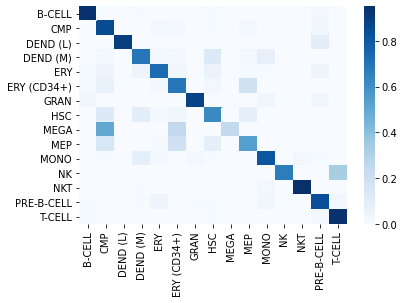

In [29]:
cdf = pd.DataFrame(data=pm.summary['validation']['confusion_matrix'], columns=pm.class_names,
                  index=pm.class_names)
sns.heatmap(cdf, cmap='Blues')

In [27]:
pm.class_names

['B-CELL',
 'CMP',
 'DEND (L)',
 'DEND (M)',
 'ERY',
 'ERY (CD34+)',
 'GRAN',
 'HSC',
 'MEGA',
 'MEP',
 'MONO',
 'NK',
 'NKT',
 'PRE-B-CELL',
 'T-CELL']

In [30]:
pm.summary['validation']['metrics']['accuracy']

0.7441331909417016

In [31]:
pm.summary['training']['metrics']['accuracy']

0.9865301724137931

In [ ]:
l_pds, l_pm = load_from_directory(adata, model_save_dir)

In [ ]:
labels, probs = l_pm.predict_pollock_dataset(l_pds, labels=True, )
labels

In [ ]:
list(l_pds.prediction_adata.obs[cell_type_key])